# Оптимизация производственных расходов металлургического комбината

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучим его, прежде чем генерировать новые признаки.

## Описание процесса обработки

## Описание данных
Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц.

## Этапы выполнения проекта

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ
4. Обучение модели
5. Тестирование модели и демонстрация её работы
6. Общий вывод по работе

## Загрузка данных

In [1]:
!pip install phik -q
!pip install catboost -q
!pip install scikeras -q

In [2]:
import os
import pandas as pd
import numpy as np

import phik
from phik.report import plot_correlation_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor, Pool

from tensorflow import keras
from tensorflow.keras import layers

import shap

from functools import reduce

RANDOM_STATE = 300625

In [ ]:
##!wget https://

In [4]:
#path_to_db = ''
#engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [5]:
try:
    with engine.connect() as conn:
        print("Подключение успешно!")
except Exception as e:
    print(f"Ошибка подключения: {e}")

Подключение успешно!


In [6]:
data_arc = pd.read_sql('SELECT * FROM data_arc', con=engine)
data_bulk = pd.read_sql('SELECT * FROM data_bulk', con=engine)
data_bulk_time = pd.read_sql('SELECT * FROM data_bulk_time', con=engine)
data_gas = pd.read_sql('SELECT * FROM data_gas', con=engine)
data_temp = pd.read_sql('SELECT * FROM data_temp', con=engine)
data_wire = pd.read_sql('SELECT * FROM data_wire', con=engine)
data_wire_time = pd.read_sql('SELECT * FROM data_wire_time', con=engine)

### Вывод

- Успешно установлено соединение с SQLite базой данных `ds-plus-final.db`, загруженной с помощью wget.
- Из БД загружены 7 таблиц с данными: `data_arc`, `data_bulk`, `data_bulk_time`, `data_gas`, `data_temp`, `data_wire`, `data_wire_time`.

## Первичное исследование таблиц

In [7]:
def analyze_dataframe(df):
    # Вывод первых 5 строк
    print("Первые 5 строк таблицы:")
    display(df.head())

    # Вывод info()
    print("\nИнформация о таблице:")
    df.info()

    # Вывод describe()
    print("\nСтатистическое описание:")
    display(df.describe(include='all'))

    # Количество и процент пропусков по столбцам
    print("\nПропуски в данных:")
    missing_data = df.isnull().sum().to_frame(name='Количество пропусков')
    missing_data['Процент пропусков'] = round(missing_data['Количество пропусков'] / len(df) * 100, 2)
    display(missing_data)

    # Количество явных дубликатов
    duplicates = df.duplicated().sum()
    print(f"\nКоличество явных дубликатов: {duplicates}")

In [8]:
analyze_dataframe(data_arc)

Первые 5 строк таблицы:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Статистическое описание:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-09-06 17:24:54,2019-09-06 17:26:15,NaN,NaN
freq,NaN,1,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175
50%,1617.000000,NaN,NaN,0.599587,0.441639
75%,2429.000000,NaN,NaN,0.830070,0.608201



Пропуски в данных:


,Количество пропусков,Процент пропусков
key,0,0.0
Начало нагрева дугой,0,0.0
Конец нагрева дугой,0,0.0
Активная мощность,0,0.0
Реактивная мощность,0,0.0



Количество явных дубликатов: 0


- Таблица содержит 14,876 записей и 5 столбцов.
- В данных нет пропущенных значений.
- Явных дубликатов также не обнаружено (количество дубликатов: 0).
- `Начало нагрева дугой` и `Конец нагрева дугой`: временные метки в формате `YYYY-MM-DD HH:MM:SS`. Все значения уникальны.
- В столбце `Реактивная мощность` присутствуют крайне низкие значения (минимальное значение -715.48), которые выглядят как аномалии или ошибки измерения. Это сильно влияет на стандартное отклонение и среднее значение. Высокий разброс значений реактивной мощности требует дополнительной проверки на наличие выбросов или некорректных данных.

**Задачи предобработки**:
   - Проверить данные на наличие аномалий в столбце `Реактивная мощность` (отрицательные значения могут быть некорректными).
   - Исследовать временные интервалы между "Начало нагрева дугой" и "Конец нагрева дугой" для анализа длительности процессов.
   - Преобразовать столбцы с временными метками в тип `datetime` для удобства временного анализа.
   - Привести названия столбцов к `snake_case`.

In [9]:
analyze_dataframe(data_bulk)

Первые 5 строк таблицы:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB

Статистическое описание:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,NaN,NaN,NaN,NaN,55,205,25,1,10,77,101,331,14,284,156
top,NaN,NaN,NaN,NaN,NaN,74.0,76.0,178.0,49.0,68.0,105.0,18.0,206.0,154.0,102.0,104.0
freq,NaN,NaN,NaN,NaN,NaN,5,15,1,1,4,8,7,224,3,99,223
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,18.277654,21.180578,75.483494,48.184126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,10.000000,228.000000,6.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,27.000000,242.000000,58.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Пропуски в данных:


,Количество пропусков,Процент пропусков
key,0,0.00
Bulk 1,2877,91.95
Bulk 2,3107,99.30
Bulk 3,1831,58.52
Bulk 4,2115,67.59
Bulk 5,3052,97.54
Bulk 6,2553,81.59
Bulk 7,3104,99.20
Bulk 8,3128,99.97
Bulk 9,3110,99.39



Количество явных дубликатов: 0


- Таблица содержит 3129 строк и 16 столбцов
- Столбцы имеют смешанные типы данных (float64, int64, object)
- Данные очень разрежены, большинство столбцов содержат значительное количество пропусков (NaN/None):
   - Bulk 2: 3107 пропусков (99.3%)
   - Bulk 8: 3128 пропусков (99.997%, всего 1 значение)
   - Bulk 1, 5, 7, 9, 10, 11, 13: более 90% пропусков
   - Наименьшее количество пропусков в Bulk 12, 14, 15
- Смешанные типы данных (числа хранятся как object, возможно из-за строковых значений)
- Отсутствие явных дубликатов (0 обнаружено)

**Рекомендации предобработки**:
   - Требуется преобразование типов данных для числовых столбцов
   - Необходимо решить, как обрабатывать столбцы с >90% пропусков (возможно исключить)
   - Стоит проверить, почему в числовых столбцах есть значения None (должны быть NaN)
   - Привести названия столбцов к `snake_case`

In [10]:
analyze_dataframe(data_bulk_time)

Первые 5 строк таблицы:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB

Статистическое описание:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-05-07 15:19:17,2019-08-31 17:10:54,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-09-06 15:01:44,2019-05-05 02:10:21,2019-09-06 17:26:33,2019-09-06 17:23:15
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Пропуски в данных:


,Количество пропусков,Процент пропусков
key,0,0.00
Bulk 1,2877,91.95
Bulk 2,3107,99.30
Bulk 3,1831,58.52
Bulk 4,2115,67.59
Bulk 5,3052,97.54
Bulk 6,2553,81.59
Bulk 7,3104,99.20
Bulk 8,3128,99.97
Bulk 9,3110,99.39



Количество явных дубликатов: 0


- Таблица содержит 3129 строк и 16 столбцов.
- Большинство столбцов имеют очень высокий процент пропущенных значений (от 58% до 99.97%). Наибольшее количество данных содержится в столбцах:
     - Bulk 14 (10.32% пропусков)
     - Bulk 12 (21.70% пропусков)
     - Bulk 15 (28.16% пропусков)
     - Bulk 3 (58.52% пропусков)
   - Некоторые столбцы практически пустые:
     - Bulk 8 - всего 1 значение
     - Bulk 2, 5, 7, 9, 13 - менее 25 значений

**Рекомендации предобработки**:
- Необходимо решить, как обрабатывать столбцы с >90% пропусков (возможно исключить).
- Требуется преобразование типов данных для столцов с временной меткой
- Привести названия столбцов к `snake_case`.


In [11]:
analyze_dataframe(data_gas)

Первые 5 строк таблицы:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Статистическое описание:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Пропуски в данных:


,Количество пропусков,Процент пропусков
key,0,0.0
Газ 1,0,0.0



Количество явных дубликатов: 0


- Таблица содержит 3239 строк и 2 столбца
- Пропуски в данных отсутствуют
- Среднее значение концентрации газа: ~11.0.
- Диапазон значений широкий: от 0.008 до 77.995, что говорит о значительной вариативности.
- Стандартное отклонение (~6.22) показывает умеренный разброс данных вокруг среднего.
- Медиана (9.84) меньше среднего, что указывает на правостороннюю асимметрию (возможно, есть выбросы в больших значениях).
- Явных дубликатов нет.
- Максимальное значение `Газ 1` (77.995) сильно отклоняется от 75% квантиля (13.77), что может быть выбросом.

**Рекомендации предобработки**:
   - Проверить данные на наличие скрытых аномалий.
   - Привести названия столбцов к `snake_case`.

In [12]:
analyze_dataframe(data_temp)

Первые 5 строк таблицы:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB

Статистическое описание:


,key,Время замера,Температура
count,18092.000000,18092,14665
unique,NaN,18092,172
top,NaN,2019-09-06 17:30:05,1593.0
freq,NaN,1,445
mean,1616.460977,NaN,NaN
std,934.641385,NaN,NaN
min,1.000000,NaN,NaN
25%,807.750000,NaN,NaN
50%,1618.000000,NaN,NaN
75%,2429.000000,NaN,NaN



Пропуски в данных:


,Количество пропусков,Процент пропусков
key,0,0.00
Время замера,0,0.00
Температура,3427,18.94



Количество явных дубликатов: 0


- Таблица содержит 18,092 строки и 3 столбца.
   - Столбцы: `key` (уникальный идентификатор), `Время замера` (временная метка), `Температура` (значение температуры).
- `Время замера` и `Температура`: хранятся как объекты (`object`), что может быть неоптимально.
- В столбце `Температура` 3,427 пропусков (18.94% от всех данных).
- `Температура`: 172 уникальных значения, наиболее частые значение — 1593.0 (встречается 445 раз).
- Явные дубликаты отсутствуют.

**Рекомендации предобработки**:
- Проверить наличие аномалий в данных (например, выбросы в `Температура`).
- Преобразовать `Время замера` в `datetime`, а `Температура` в числовой тип (`float64`).
- Устранить пропуски в `Температура` в зависимости от контекста.
- Привести названия столбцов к `snake_case`.


In [13]:
analyze_dataframe(data_wire)

Первые 5 строк таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB

Статистическое описание:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079,63,14,1,73,11,19,29
unique,NaN,NaN,713,56,14,1,69,10,13,25
top,NaN,NaN,30.09968,0.144144,24.148801,15.132,18.086641,12.354473,46.187439000000005,30.066399
freq,NaN,NaN,20,3,1,1,2,2,3,3
mean,1623.426485,100.895853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,42.012518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.918800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,72.115684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,100.158234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,126.060483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Пропуски в данных:


,Количество пропусков,Процент пропусков
key,0,0.00
Wire 1,26,0.84
Wire 2,2002,64.98
Wire 3,3018,97.96
Wire 4,3067,99.55
Wire 5,3080,99.97
Wire 6,3008,97.63
Wire 7,3070,99.64
Wire 8,3062,99.38
Wire 9,3052,99.06



Количество явных дубликатов: 0


- Таблица содержит 3081 запись и 10 столбцов.
- Столбец `Wire 1` заполнен почти полностью (3055 из 3081, пропуски ~0.84%).
- Остальные столбцы (`Wire 2`-`Wire 9`) содержат значительное количество пропусков:
     - `Wire 2`: ~65% пропусков.
     - `Wire 3`-`Wire 9`: от ~97% до ~99.97% пропусков (`Wire 5` содержит всего 1 заполненное значение, а `Wire 4`, `Wire 7` и другие — менее 20).
- `key` и `Wire 1` имеют числовые типы (`int64` и `float64` соответственно).
- `Wire 2`-`Wire 9` имеют тип `object`, что может указывать на смешанные или строковые данные.
- Для `Wire 1`:
     - Среднее значение: ~100.9, стандартное отклонение: ~42.01.
     - Минимум: ~1.92, максимум: ~330.31.
     - Медиана (~100.16) близка к среднему, что может указывать на нормальное распределение.
- Для остальных столбцов статистика не рассчитана из-за большого числа пропусков или типа `object`.
- `Wire 2` содержит 713 уникальных значений (при 1079 заполненных строках), что указывает на умеренную повторяемость.
- В остальных столбцах уникальных значений мало (например, `Wire 5` — всего 1 значение).
- Явных дубликатов нет.
- Столбцы `Wire 2`-`Wire 9` имеют тип `object`, хотя, судя по примерам, должны быть числовыми (`float64`). Возможно, есть строковые значения (например, `"None"`), мешающие автоматическому преобразованию.

**Рекомендации предобработки**:
- Проверить столбцы `Wire 2`-`Wire 9` на наличие нечисловых значений и преобразовать их в `float64`.
- Необходимо решить, как обрабатывать столбцы с >90% пропусков (возможно исключить).
- Привести названия столбцов к `snake_case`.


In [14]:
analyze_dataframe(data_wire_time)

Первые 5 строк таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Статистическое описание:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3055,1079,63,14,1,73,11,19,29
top,NaN,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
freq,NaN,1,1,1,1,1,1,1,1,1
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Пропуски в данных:


,Количество пропусков,Процент пропусков
key,0,0.00
Wire 1,26,0.84
Wire 2,2002,64.98
Wire 3,3018,97.96
Wire 4,3067,99.55
Wire 5,3080,99.97
Wire 6,3008,97.63
Wire 7,3070,99.64
Wire 8,3062,99.38
Wire 9,3052,99.06



Количество явных дубликатов: 0


- Таблица содержит 3081 запись (строк) и 10 столбцов.
- **Wire 1**: Наиболее заполненный столбец (3055/3081, ~99.2% заполненности).
- Остальные столбцы содержат значительное количество пропусков:
  - Wire 2: ~35% заполненности
  - Wire 3-Wire 9: менее 3% заполненности каждый (особенно Wire 5 - всего 1 значение)
  - Wire 4, Wire 5, Wire 7 имеют более 99.5% пропусков.
- Все временные метки в каждом столбце уникальны.
- В таблице нет явных дубликатов строк.

**Рекомендации по предобработке**:
- Необходимо решить, как обрабатывать столбцы с >90% пропусков (возможно исключить).
- Требуется преобразование типов данных для столцов с временной меткой.
- Привести названия столбцов к `snake_case`.



### Вывод

В данном проведен первичный анализ датафреймов:  
- Вывод первых 5 строк для ознакомления с данными.  
- Проверка типов данных.  
- Анализ основных статистик с помощью `describe()`.  
- Оценка количества и процента пропусков по каждому столбцу.  
- Проверка данных на дубликаты.
- Приведены задачи по предобработке.

 ## Предобработка данных

### Данные об электродах

In [15]:
def convert_column_types(df: pd.DataFrame, source_type: str, target_type: str) -> None:
    cols_to_convert = df.select_dtypes(include=[source_type]).columns
    for col in cols_to_convert:
        df[col] = df[col].astype(target_type)

In [16]:
# Переименование столбцов
data_arc = data_arc.rename(columns={
    'Начало нагрева дугой': 'arc_heating_start',
    'Конец нагрева дугой': 'arc_heating_end',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
})

# Преобразование столбцов с датами в datetime
convert_column_types(data_arc, source_type='object', target_type='datetime64[ns]')

# Проверка результата
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   arc_heating_start  14876 non-null  datetime64[ns]
 2   arc_heating_end    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [17]:
print(f"Количество уникальных партий в данных об электродах: {data_arc['key'].nunique()}")

Количество уникальных партий в данных об электродах: 3214


ПОсмотрим на аномалию в `reactive_power`.

In [18]:
data_arc.query('reactive_power < 0')

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [19]:
data_arc.query('key == 2116')

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Удалим все записи партии 2116.

In [20]:
data_arc = data_arc.query('key != 2116')

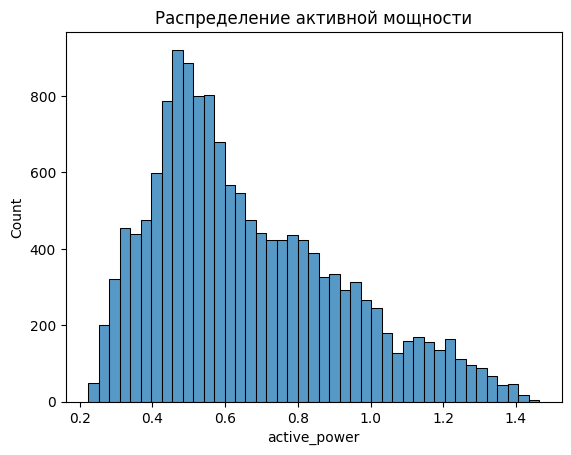

In [21]:
sns.histplot(data=data_arc, x='active_power')
plt.title('Распределение активной мощности')
plt.show()

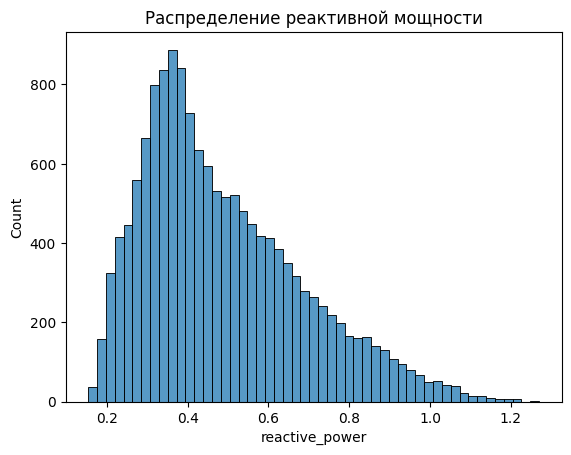

In [22]:
sns.histplot(data=data_arc, x='reactive_power')
plt.title('Распределение реактивной мощности')
plt.show()

Распределения имеют правый хвост, большинство наблюдений лежат в средней части диапазона, что может говорить о преобладании умеренных значений активной мощности.  

Сгенерируем новые признаки.

In [23]:
# 1. Длительность нагрева (в секундах)
data_arc['heating_dur'] = (data_arc['arc_heating_end'] - data_arc['arc_heating_start']).dt.total_seconds()

# 2. Полная мощность
data_arc['full_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

# 3. Соотношение активной и реактивной мощности
data_arc['power_ratio'] = data_arc['active_power'] / data_arc['reactive_power']

# 4. Интервал между окончанием предыдущего нагрева и началом следующего
# Сортируем данные по электроду (key) и времени начала нагрева
data_arc = data_arc.sort_values(by=['key', 'arc_heating_start'])

data_arc['interval_between_heatings'] = (
    data_arc['arc_heating_start'] - data_arc.groupby('key')['arc_heating_end'].shift(1)
).dt.total_seconds()
data_arc['interval_between_heatings'] = data_arc['interval_between_heatings'].fillna(0)

In [24]:
data_arc.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,heating_dur,full_power,power_ratio,interval_between_heatings
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,1.444382,0.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,1.603680,86.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,1.348123,71.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,1.364539,218.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,1.347126,110.0


In [25]:
data_arc.describe()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,heating_dur,full_power,power_ratio,interval_between_heatings
count,14872.000000,14872,14872,14872.000000,14872.000000,14872.000000,14872.000000,14872.000000,14872.000000
mean,1615.085732,2019-07-05 12:17:07.251008512,2019-07-05 12:19:58.939012864,0.662753,0.487112,171.688004,0.823385,1.373513,244.281603
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,11.000000,0.275718,1.001742,0.000000
25%,806.000000,2019-06-03 23:00:25.249999872,2019-06-03 23:04:15.750000128,0.467114,0.337175,107.000000,0.578813,1.280145,74.000000
50%,1616.000000,2019-07-03 01:13:25,2019-07-03 01:15:47,0.599587,0.441667,147.000000,0.746591,1.379778,158.000000
75%,2429.000000,2019-08-07 22:59:29.500000,2019-08-07 23:01:33,0.830314,0.608201,214.000000,1.030390,1.471221,287.000000
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,907.000000,1.898158,1.857442,14528.000000
std,934.661090,NaN,NaN,0.258916,0.197623,98.193604,0.323494,0.130918,399.456668


- **Средняя длительность нагрева (heating_dur):**  
     - **171.69 секунды** (~2.86 минуты), но с большим разбросом (std = 98.19).  
     - Минимальная длительность: **11 секунд**, максимальная — **907 секунд** (~15 минут).  
- **Интервал между нагревами (interval_between_heatings):**  
     - В среднем **244.28 секунды** (~4 минуты), но есть экстремальные значения:  
       - Минимум: **0 секунд** (нагревы идут подряд), максимум: **14 528 секунд** (~4 часа).  
     - 75% интервалов длятся менее **287 секунд** (~4.8 минуты).
- **Полная мощность (full_power):**  
     - Среднее: **0.823**, медиана: **0.747**.  
     - Максимальное значение: **1.898**.  
- **Коэффициент мощности (power_ratio)**  
   - Среднее: **1.374**, медиана: **1.380**.  
   - Диапазон: от **1.002** до **1.857**, что указывает на **стабильность** (std = 0.131).  
- **Временной охват**  
   - Данные охватывают период с **3 мая 2019** по **6 сентября 2019**.  
   - Средняя дата начала нагрева: **5 июля 2019, ~12:17**.  

Проведем агрегацию данных: удалим столбцы с временными метками, сгруппируем данные по ключу `key` и суммируем все числовые значения для каждого ключа.

In [26]:
data = (
    data_arc
    .drop(columns=['arc_heating_start', 'arc_heating_end'])
    .groupby('key', as_index=False)
    .sum()
)

In [27]:
data.head()

,key,active_power,reactive_power,heating_dur,full_power,power_ratio,interval_between_heatings
0,1,3.036730,2.142821,1098.0,3.718736,7.107850,485.0
1,2,2.139408,1.453357,811.0,2.588349,5.916805,333.0
2,3,4.063641,2.937457,655.0,5.019223,6.980344,870.0
3,4,2.706489,2.056992,741.0,3.400038,5.229785,352.0
4,5,2.252950,1.687991,869.0,2.816980,5.315577,493.0


### Данные о сыпучих материалах

In [28]:
convert_column_types(data_bulk, source_type='object', target_type='float64')
convert_column_types(data_bulk_time, source_type='object', target_type='datetime64[ns]')

Пропуски в `data_bulk` и `data_bulk_time` означают, что материал не добавляли в партию. Заполнил пропуски нулями.

In [29]:
data_bulk.fillna(0, inplace=True)
data_bulk_time.fillna(pd.NaT, inplace=True)

In [30]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [31]:
data_bulk_time.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим на записи с `Bulk 12` больше 1000.

In [32]:
data_bulk[data_bulk['Bulk 12'] > 1000]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0


In [33]:
data_bulk_time.query('key == 322')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,2019-05-15 23:03:53,NaT,2019-05-15 22:59:04,2019-05-15 22:51:21,NaT,NaT,2019-05-15 22:42:51,NaT,NaT,NaT,NaT,2019-05-15 22:16:39,NaT,2019-05-15 22:11:53,NaT


Оставим данную запись, между подачей `Bulk 12` и следующего сыпучего материала прошло примерно 25 минут, не похоже на аномалию.

Создадим новый столбец `bulk_time_period` временного интервала в секундах между первой и последней подачами сыпучего материала, удалим исходные столбцы.

In [34]:
# Список столбцов с временными метками
bulk_columns = [f'Bulk {i}' for i in range(1, 16)]

# Функция, которая для каждой строки вычисляет промежуток между min и max временем в секундах
def time_interval_seconds(row):
    times = row[bulk_columns].dropna()
    if len(times) == 0:
        return None
    td = times.max() - times.min()
    return td.total_seconds()

# Создаем новый столбец с интервалом в секундах
data_bulk_time['bulk_time_period'] = data_bulk_time.apply(time_interval_seconds, axis=1)
data_bulk_time.drop(columns=bulk_columns, inplace=True)

In [35]:
data_bulk_time.head()

,key,bulk_time_period
0,1,1085.0
1,2,1000.0
2,3,983.0
3,4,878.0
4,5,205.0


In [36]:
data_bulk_time.describe()

,key,bulk_time_period
count,3129.000000,3129.000000
mean,1624.383509,964.906679
std,933.337642,798.088025
min,1.000000,0.000000
25%,816.000000,485.000000
50%,1622.000000,877.000000
75%,2431.000000,1311.000000
max,3241.000000,13683.000000


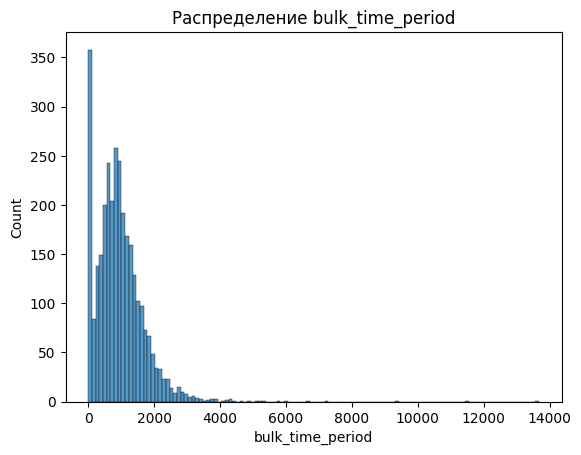

In [37]:
sns.histplot(data=data_bulk_time, x='bulk_time_period')
plt.title('Распределение bulk_time_period')
plt.show()

**Добавим два новых столбца** в таблицу `data_bulk`:  
   - `count_bulk` — количество ненулевых значений в столбцах `Bulk 1`–`Bulk 15` для каждой строки,  
   - `sum_bulk` — сумма всех значений в этих столбцах.  

**Удалим лишние столбцы**, оставив только `Bulk 12`, `Bulk 14` и `Bulk 15`.  

**Переименуем оставшиеся столбцы** в `bulk_12`, `bulk_14` и `bulk_15` для единообразия.  

In [38]:
# Создаем новый столбец с количеством подачи сыпучих материалов
data_bulk['count_bulk'] = (data_bulk[bulk_columns] != 0).sum(axis=1)

# Создаем новый столбец с суммой объема подачи сыпучих материалов
data_bulk['sum_bulk'] = data_bulk[bulk_columns].sum(axis=1)

# Список столбцов, которые нужно оставить
columns_to_keep = ['Bulk 12', 'Bulk 14', 'Bulk 15']

# Формируем список столбцов для удаления (все из bulk_columns, кроме columns_to_keep)
columns_to_drop = [col for col in bulk_columns if col not in columns_to_keep]

# Удаляем ненужные столбцы
data_bulk.drop(columns=columns_to_drop, inplace=True)
data_bulk.rename(
    columns={
        'Bulk 12': 'bulk_12',
        'Bulk 14': 'bulk_14',
        'Bulk 15': 'bulk_15'
    },
    inplace=True
)

In [39]:
data_bulk.describe()

,key,bulk_12,bulk_14,bulk_15,count_bulk,sum_bulk
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,203.948226,152.706616,115.319271,3.566315,595.503356
std,933.337642,151.419639,81.091421,84.488698,1.216165,276.557794
min,1.000000,0.000000,0.000000,0.000000,1.000000,19.000000
25%,816.000000,105.000000,104.000000,0.000000,3.000000,429.000000
50%,1622.000000,206.000000,148.000000,106.000000,4.000000,591.000000
75%,2431.000000,263.000000,202.000000,204.000000,4.000000,772.000000
max,3241.000000,1849.000000,636.000000,405.000000,7.000000,3235.000000


**Общий объем подачи сыпучих материалов (`sum_bulk`)**  
   - Средний объем сыпучих материалов за период — **595.5**, но разброс значительный (стандартное отклонение **~276.6**).  
   - Минимальное значение — **19**, максимальное — **3235**, что говорит о сильной вариативности процессов.  
   - Медианное значение (**591**) близко к среднему, значит, распределение относительно симметрично, но есть выбросы (особенно в max).  

**Количество подач сыпучих материалов (`count_bulk`)**  
   - Диапазон подач сыпучих материалов— от 1 до 7.  
   - В 75% партий используют 4 или меньше подач сыпучих материалов.  


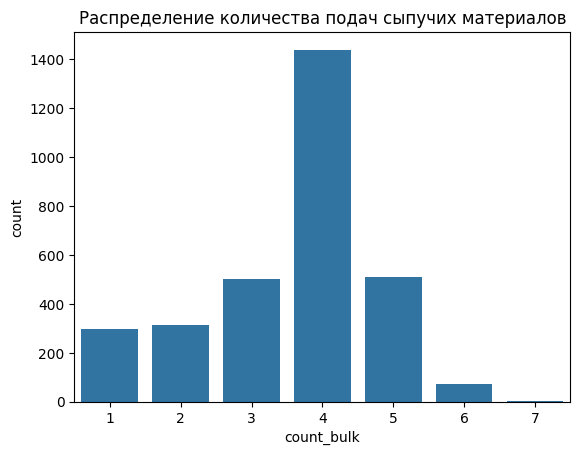

In [40]:
sns.countplot(data=data_bulk, x='count_bulk')
plt.title('Распределение количества подач сыпучих материалов')
plt.show()

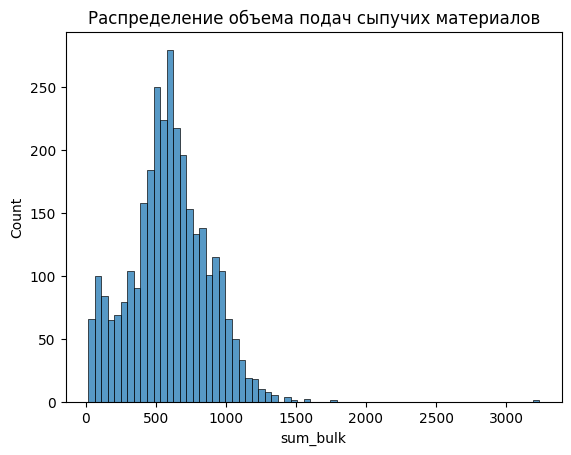

In [41]:
sns.histplot(data=data_bulk, x='sum_bulk')
plt.title('Распределение объема подач сыпучих материалов')
plt.show()

### Данные о продувке сплава газом

In [42]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas'})

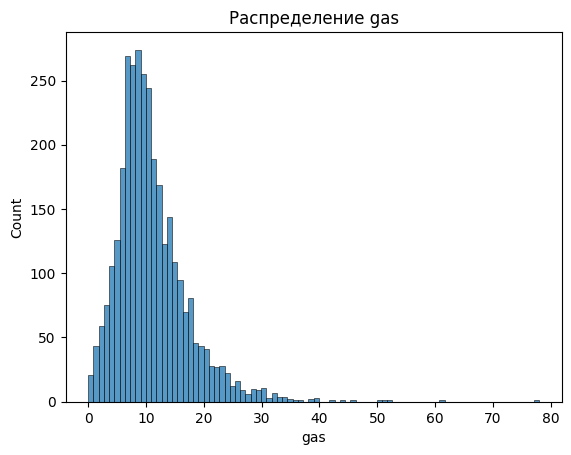

In [43]:
sns.histplot(data=data_gas, x='gas')
plt.title('Распределение gas')
plt.show()

Основная часть значений сосредоточена в диапазоне примерно от 0 до 20, с пиком около 7-10. Распределение сильно скошено вправо — есть редкие, но заметные случаи, когда значение газа достигает значительно больших чисел (до 70-80). Максимальная частота чуть больше 250 наблюдений.

### Данные об измерениях температуры

Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.
Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные.

In [44]:
data_temp.columns = ['key', 'measure_time', 'temp']

In [45]:
data_temp['measure_time'] = pd.to_datetime(data_temp['measure_time'])
data_temp['temp'] = pd.to_numeric(data_temp['temp'], errors='coerce')

In [46]:
data_temp.describe()

,key,measure_time,temp
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


- Данные о температуре (`temp`) доступны не для всех записей (только для 14,665).
   - **Средняя температура**: ~1590.72.
   - **Медиана**: 1590, что совпадает со средним, предполагая симметричное распределение.
   - **Минимальная температура**: 1191 (аномально низкое значение, возможно выброс).
   - **Максимальная температура**: 1705.
   - **Разброс**: Стандартное отклонение ~20.39, что указывает на относительно стабильные значения (большинство данных в пределах 1570–1610).
   - **25-й и 75-й перцентили**: 1580 и 1599, подтверждающие узкий диапазон колебаний.

In [47]:
data_temp.fillna(0, inplace=True)

Сгруппируем данные по столбцу `key`, для каждой группы вычислим начальную температуру (`temp_start`), конечную температуру (`temp_end`) и длительность измерений в секундах (`duration_measure`).

In [48]:
grouped = data_temp.groupby('key')

temp = data_temp.groupby('key').apply(
    lambda g: pd.Series({
        'temp_start': g.loc[g['measure_time'].idxmin(), 'temp'],
        'temp_end': g.loc[g['measure_time'].idxmax(), 'temp'],
        'duration_measure': (g['measure_time'].max() - g['measure_time'].min()).total_seconds()
    }),
    include_groups=False
).reset_index()

In [49]:
temp.describe()

,key,temp_start,temp_end,duration_measure
count,3216.000000,3216.000000,3216.000000,3216.000000
mean,1622.199316,1588.592040,1228.744714,2249.620958
std,935.088523,29.137454,671.403549,1317.270815
min,1.000000,1191.000000,0.000000,0.000000
25%,815.750000,1572.000000,1574.000000,1528.000000
50%,1622.500000,1588.000000,1590.000000,1987.000000
75%,2431.250000,1606.000000,1597.000000,2706.000000
max,3241.000000,1684.000000,1700.000000,23674.000000


In [50]:
temp.head()

,key,temp_start,temp_end,duration_measure
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0


**temp_start (стартовая температура):**  
   - Средняя стартовая температура — около 1588.6.  
   - Значение меняется в диапазоне от 1191 до 1684.

**temp_end (конечная температура):**  
   - Средняя конечная температура – 1228.7.  
   - Здесь разброс гораздо шире (стандартное отклонение ~671).  
   - Минимальное значение — 0, максимальное — 1700.

**duration_measure (время измерения):**  
   - Средняя длительность — около 2249  
   - Максимальная длительность — 23674, в 10 раз больше третьего квартиля (~2706). Большая часть данных сосредоточена ниже 3000.  
   - Минимум равен нулю — возможно, некоторые измерения не производились.

In [51]:
temp.query('temp_start<1500')

,key,temp_start,temp_end,duration_measure
855,867,1191.0,1599.0,2684.0
1201,1214,1208.0,1591.0,2573.0
1604,1619,1218.0,1590.0,558.0
2036,2052,1227.0,1592.0,2268.0
2538,2561,1204.0,0.0,1936.0


In [52]:
temp.query('temp_end<1500')

,key,temp_start,temp_end,duration_measure
2477,2500,1539.0,0.0,1500.0
2478,2501,1587.0,0.0,2866.0
2479,2502,1583.0,0.0,1516.0
2480,2503,1603.0,0.0,2800.0
2481,2504,1583.0,0.0,1919.0
...,...,...,...,...
3211,3237,1569.0,0.0,1470.0
3212,3238,1584.0,0.0,1102.0
3213,3239,1598.0,0.0,3185.0
3214,3240,1617.0,0.0,4205.0


In [53]:
temp.query('duration_measure < 10')

,key,temp_start,temp_end,duration_measure
192,195,1583.0,1583.0,0.0
276,279,1603.0,1603.0,0.0


Отфильтруем данные, оставляя только записи, где стартовая и конечная температуры не меньше 1500, а длительность измерения не равна нулю.

In [54]:
temp = temp.query("temp_start >= 1500 and temp_end >= 1500 and duration_measure != 0")

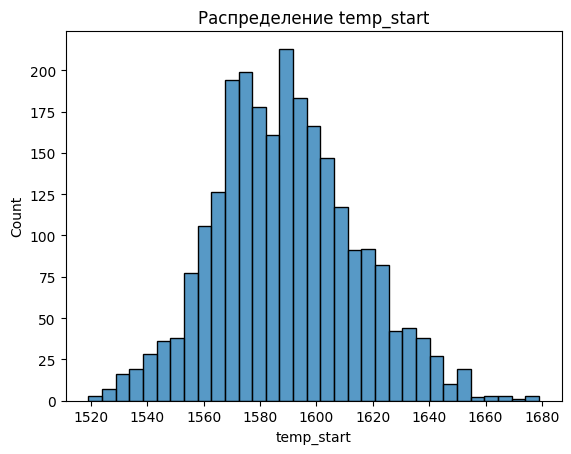

In [55]:
sns.histplot(data=temp, x='temp_start')
plt.title('Распределение temp_start')
plt.show()

Распределение примерно нормальное — гистограмма выглядит как колокол с пиком в центре. Пик около 1580-1600, данные относительно симметричны, справа — длинный хвост с меньшим количеством значений, уходящих до 1680. Основная часть данных сосредоточена между 1550 и 1650.

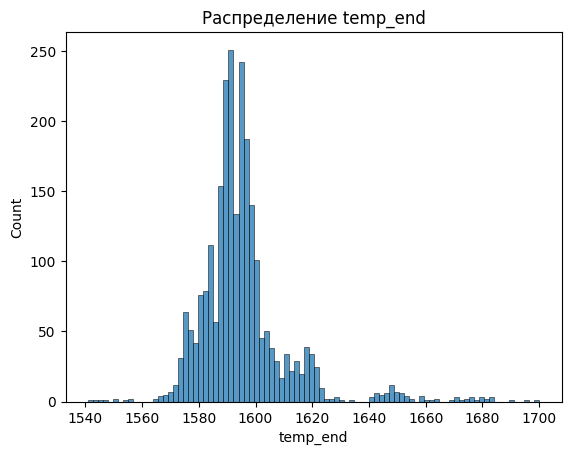

In [56]:
sns.histplot(data=temp, x='temp_end')
plt.title('Распределение temp_end')
plt.show()

Распределение с положительной асимметрией (правый скошенный хвост) — основная часть данных сосредоточена около значения 1570-1620, но с длинным хвостом справа, уходящим до 1700. Пик наблюдается в диапазоне примерно 1585-1595 — именно здесь сосредоточено наибольшее количество наблюдений.

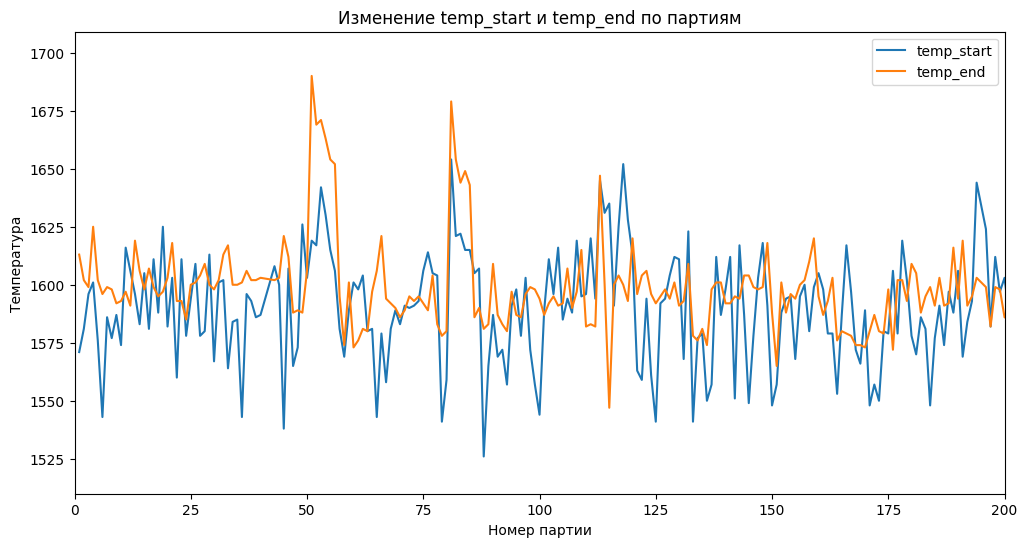

In [57]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=temp, x='key', y='temp_start', label='temp_start')
sns.lineplot(data=temp, x='key', y='temp_end', label='temp_end')
plt.title('Изменение temp_start и temp_end по партиям')
plt.xlabel('Номер партии')
plt.ylabel('Температура')
plt.xlim(0, 200)
plt.legend()
plt.show()

Обе переменные колеблются в похожем диапазоне температур — примерно от 1520 до 1700. `temp_end`  обычно выше `temp_start`. Это говорит о тенденции нагрева или увеличения температуры по ходу наблюдений. Значения`temp_start` более резкие и хаотичные, значения `temp_end` более сглажены.

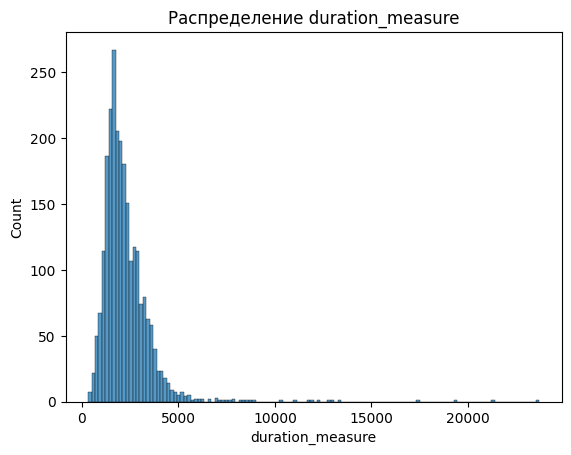

In [58]:
sns.histplot(data=temp, x='duration_measure')
plt.title('Распределение duration_measure')
plt.show()

Распределение имеет выраженную положительную асимметрию, большинство значений сосредоточено в около 0–5000, но есть редкие, гораздо более большие значения, тянущие хвост вправо до 20000+. Распределение не симметрично и не является нормальным.

### Данные о проволочных материалах

In [59]:
convert_column_types(data_wire, source_type='object', target_type='float64')
convert_column_types(data_wire_time, source_type='object', target_type='datetime64[ns]')

In [60]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Пропуски в `data_wire` и `data_wire_time` означают, что материал не добавляли в партию. Заполним пропуски нулями.

In [61]:
data_wire.fillna(0, inplace=True)
data_wire_time.fillna(pd.NaT, inplace=True)

Вычислим временной интервал (в секундах) между первой и поледней временными метками для каждой партии в столбцах Wire 1–Wire 9, сохраним результат в новый столбец `wire_time_period` и удалим исходные столбцы с временными данными.

In [62]:
# Список столбцов с временными метками
wire_columns = [f'Wire {i}' for i in range(1, 10)]

# Функция, которая для каждой строки вычисляет промежуток между min и max временем в секундах
def time_interval_seconds(row):
    times = row[wire_columns].dropna()
    if len(times) == 0:
        return None

    # Преобразуем строки в datetime
    try:
        times = pd.to_datetime(times)
        td = times.max() - times.min()
        return td.total_seconds()
    except:
        return None  # если возникла ошибка преобразования времени

# Создаем новый столбец с интервалом в секундах
data_wire_time['wire_time_period'] = data_wire_time.apply(time_interval_seconds, axis=1)
data_wire_time.drop(columns=wire_columns, inplace=True)

In [63]:
data_wire_time.describe()

,key,wire_time_period
count,3081.000000,3081.000000
mean,1623.426485,214.519312
std,932.996726,396.131967
min,1.000000,0.000000
25%,823.000000,0.000000
50%,1619.000000,0.000000
75%,2434.000000,401.000000
max,3241.000000,5937.000000


В датасете 3081 наблюдений.
**Столбец `wire_time_period`**:  
   - **Сильный перекос в распределении**:  
     - **Медиана** и **25%-квантиль** равны 0, а **среднее** (~214) значительно выше медианы. Это означает, что большинство значений близки к 0, но есть редкие экстремально высокие значения (максимум — 5937).  
     - **75%-квантиль** (401) показывает, что лишь 25% данных превышают 401.  
   - **Выбросы**: Максимальное значение (5937) сильно отличается от 75%-квантиля, что подтверждает наличие аномально высоких значений.

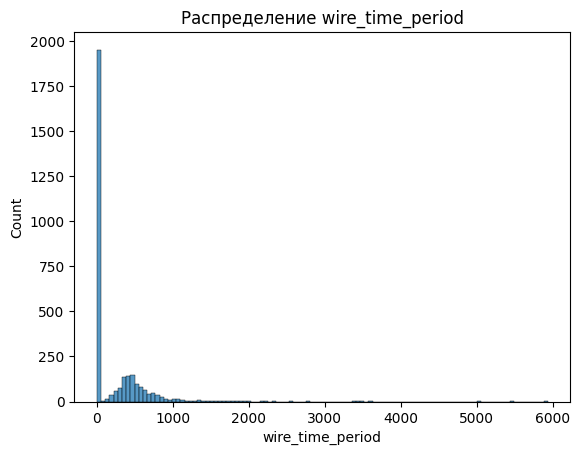

In [64]:
sns.histplot(data=data_wire_time, x='wire_time_period')
plt.title('Распределение wire_time_period')
plt.show()

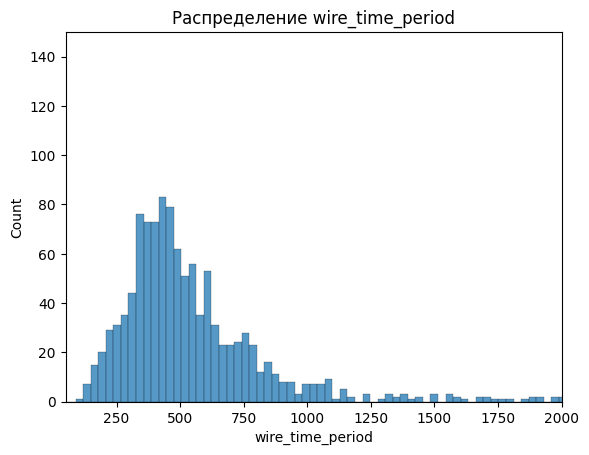

In [65]:
sns.histplot(data=data_wire_time, x='wire_time_period', bins=200)
plt.title('Распределение wire_time_period')
plt.xlim(50, 2000)
plt.ylim(0, 150)
plt.show()

Распределение несимметрично и смещено вправо. Наибольшее количество наблюдений находится примерно в интервале от 200 до 600. Значения wire_time_period свыше 1000 встречаются редко, но присутствуют.

Создадим два новых столбца с количеством и объемом подачи проволочных материалов, удалим все столбцы, кроме `Wire 1`.

In [66]:
# Создаем новый столбец с количеством подачи проволочных материалов
data_wire['count_wire'] = (data_wire[wire_columns] != 0).sum(axis=1)

# Создаем новый столбец с суммой объема подачи проволочных материалов
data_wire['sum_wire'] = data_wire[wire_columns].sum(axis=1)

# Список столбцов, которые нужно оставить
wire_to_keep = ['Wire 1']

# Формируем список столбцов для удаления (все из bulk_columns, кроме columns_to_keep)
wire_to_drop = [col for col in wire_columns if col not in wire_to_keep]

# Удаляем ненужные столбцы
data_wire.drop(columns=wire_to_drop, inplace=True)
data_wire.rename(columns={'Wire 1': 'wire_1'}, inplace=True)

In [67]:
data_wire.describe()

,key,wire_1,count_wire,sum_wire
count,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,1.409932,123.723326
std,932.996726,42.841120,0.578078,66.082966
min,1.000000,0.000000,1.000000,1.918800
25%,823.000000,70.281120,1.000000,86.112000
50%,1619.000000,100.114563,1.000000,114.179523
75%,2434.000000,125.798405,2.000000,150.181198
max,3241.000000,330.314424,5.000000,663.851766


**Столбец `count_wire`**  
   - **В основном 1–2 подачи** (медиана = 1, 75%-квантиль = 2).  
   - **Редкие случаи до 5 подач** (максимум = 5), что может указывать на сложные режимы сварки.  

**Столбец `sum_wire`**  
   - **Типичные значения 86–150** (25–75%-квантили), среднее ≈ 123.72.  
   - **Есть экстремальные случаи** (максимум ≈ 663.85).  

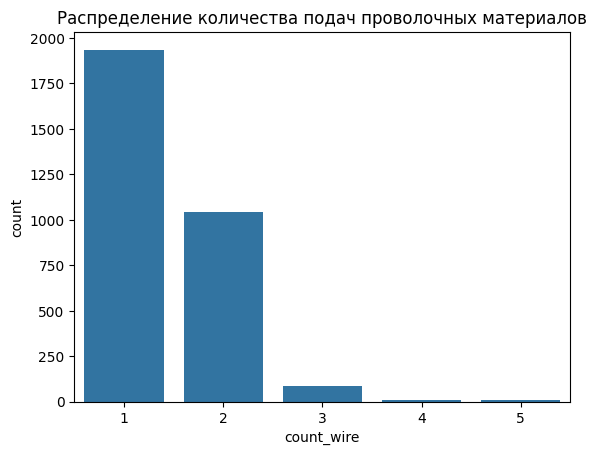

In [68]:
sns.countplot(data=data_wire, x='count_wire')
plt.title('Распределение количества подач проволочных материалов')
plt.show()

Чаще всего подача проволочных материалов происходит однократно. Значение 2 встречается значительно реже (около 1000), тогда как значения 3, 4 и 5 встречаются крайне редко.

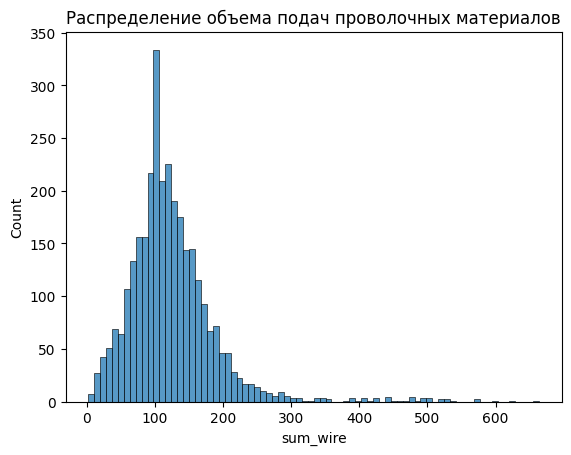

In [69]:
sns.histplot(data=data_wire, x='sum_wire')
plt.title('Распределение объема подач проволочных материалов')
plt.show()

Распределение положительно скошено. Наибольшее количество наблюдений находится примерно в интервале от 50 до 150. Здесь наблюдается явный пик распределения с максимальным числом значений около 100. Значения `sum_wire` выше 200 встречаются значительно реже, и экстремально большие значения (свыше 500) — это редкие выбросы.

### Вывод

В данном разделе была проведена комплексная предобработка и исследование исходных данных по нескольким ключевым этапам процесса:

1. **Данные об электродах**:  
   - Привели даты к формату `datetime`, удалили аномальные партии (с отрицательной реактивной мощностью).  
   - Сгенерировали новые полезные признаки: длительность нагрева, полная мощность, коэффициент мощности и интервалы между нагревами.  
   - Выявили, что длительность нагрева варьируется от 11 секунд до 15 минут, при этом интервалы между нагревами чаще составляют около 4 минут.

2. **Данные о сыпучих материалах**:  
   - Заполнили пропуски нулями, посчитали количество и сумму подачи материалов для каждой партии.  
   - Рассчитали временной интервал подачи материалов.  
   - Выделили основные типы сыпучих материалов (Bulk 12, 14, 15), выявили большую вариативность объемов и относительно небольшое количество подач за партию.

3. **Данные о продувке газом**:  
   - Показано, что значения газа в основном сосредоточены около 7–10, с редкими высокими значениями до 70–80.

4. **Данные о температуре**:  
   - Обработали измерения температуры, выбросили аномальные записи с температурами ниже 1500 и с нулевой длительностью измерений.  
   - Вычислили начальную и конечную температуры партии, отметили тенденцию повышения температуры в процессе.

5. **Данные о проволочных материалах**:  
   - Заполнили пропуски, вычислили временные интервалы подачи, выявили сильный перекос в распределении с редкими, но значительными длинными интервалами.  
   - Посчитали количество и сумму подачи проволочных материалов, отметили, что в большинстве партий подачи однократны, с редкими случаями до 5 подач.

## Объединение таблиц

In [70]:
dfs = [data, data_bulk, data_bulk_time, data_gas, temp, data_wire, data_wire_time]

df = reduce(lambda left, right: pd.merge(left, right, on='key', how='inner'), dfs)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2324 non-null   int64  
 1   active_power               2324 non-null   float64
 2   reactive_power             2324 non-null   float64
 3   heating_dur                2324 non-null   float64
 4   full_power                 2324 non-null   float64
 5   power_ratio                2324 non-null   float64
 6   interval_between_heatings  2324 non-null   float64
 7   bulk_12                    2324 non-null   float64
 8   bulk_14                    2324 non-null   float64
 9   bulk_15                    2324 non-null   float64
 10  count_bulk                 2324 non-null   int64  
 11  sum_bulk                   2324 non-null   float64
 12  bulk_time_period           2324 non-null   float64
 13  gas                        2324 non-null   float

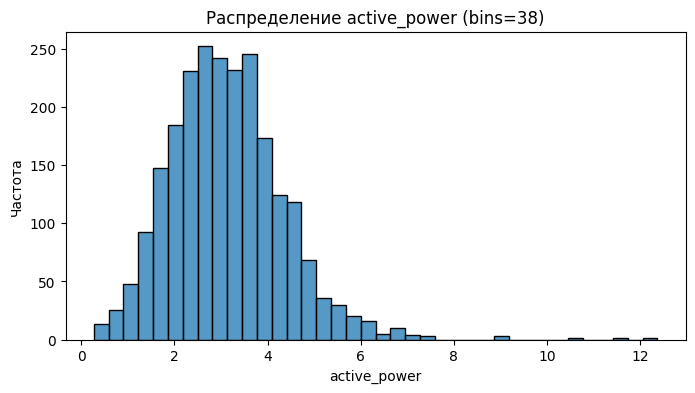

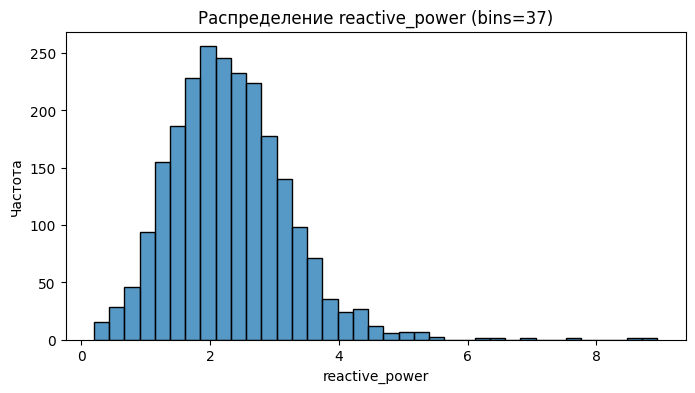

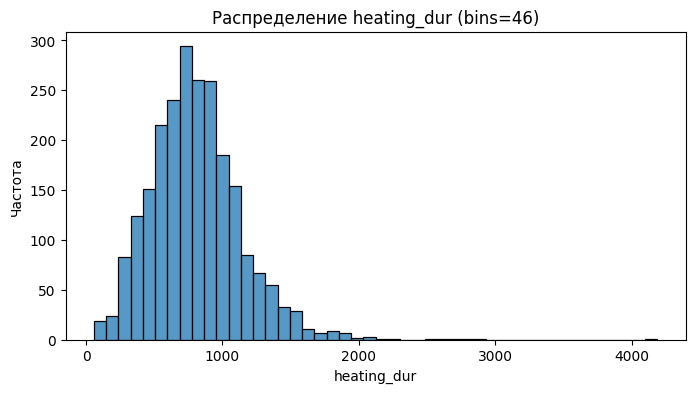

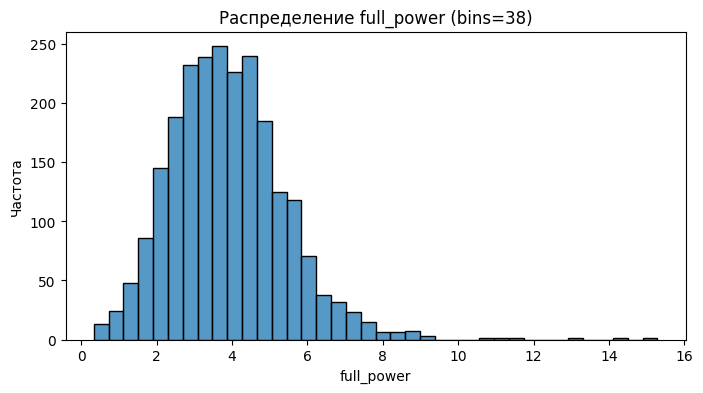

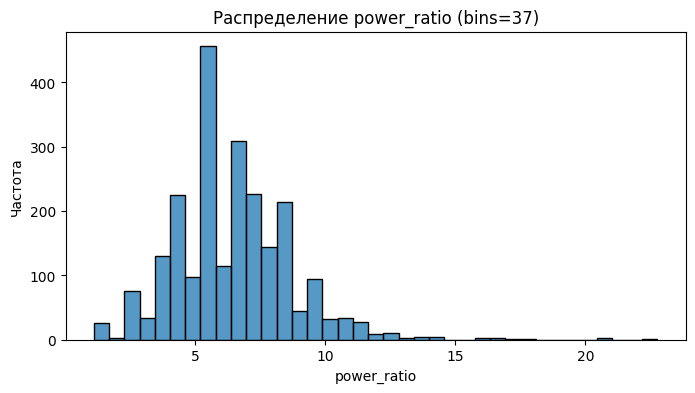

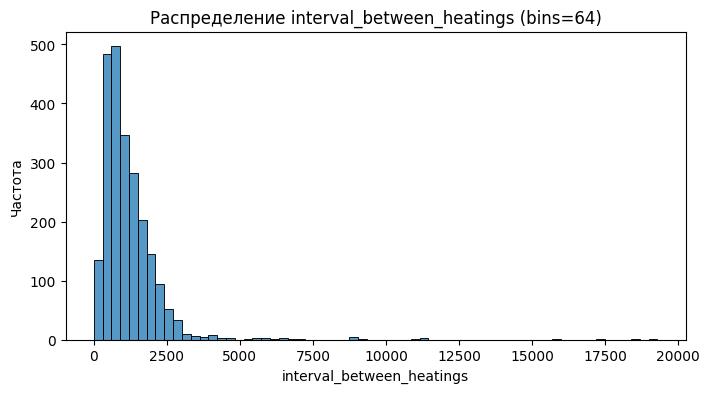

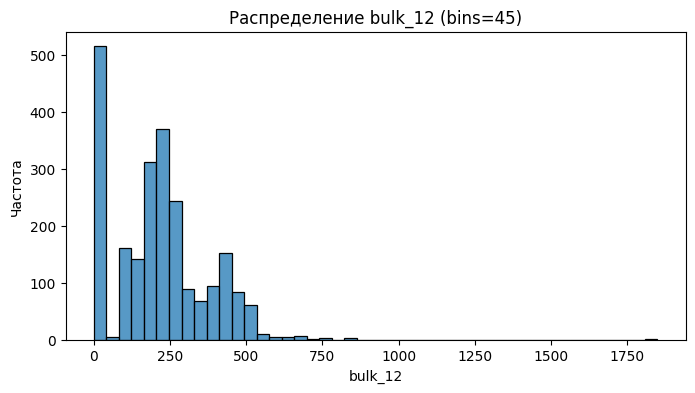

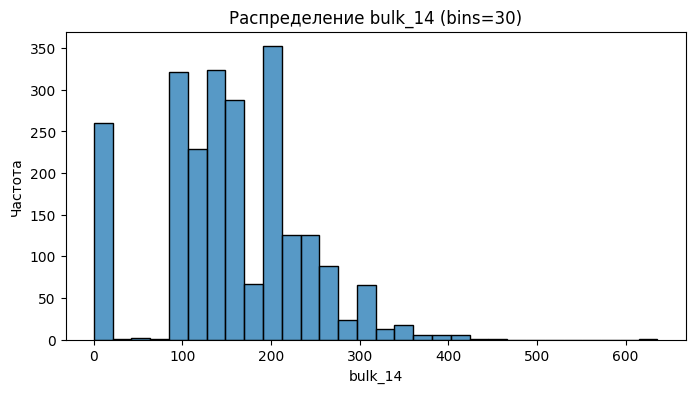

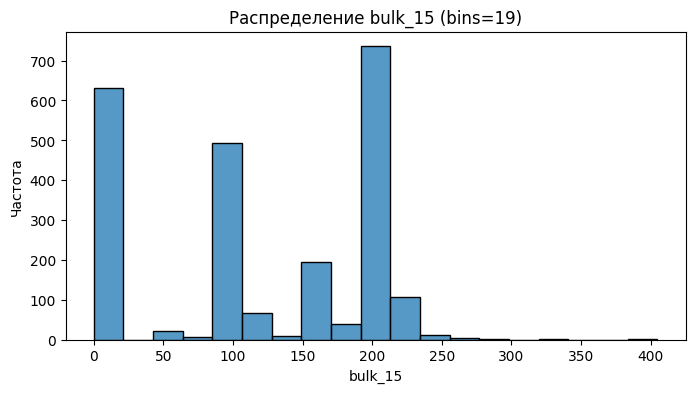

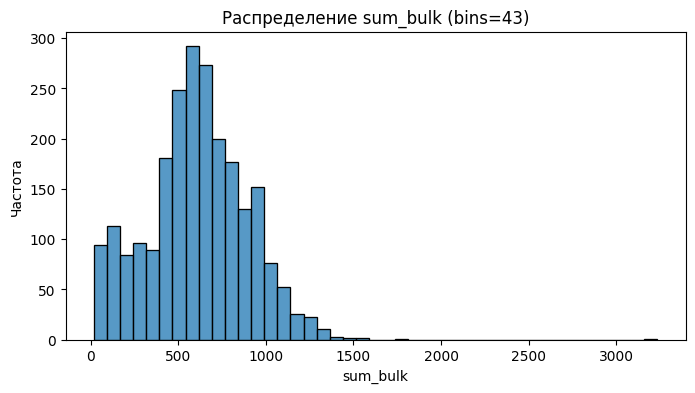

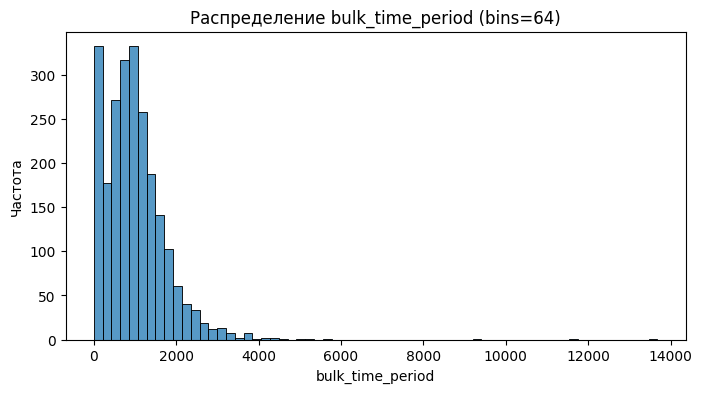

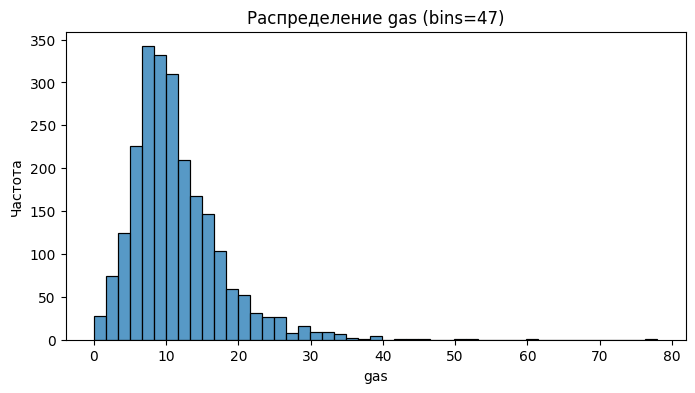

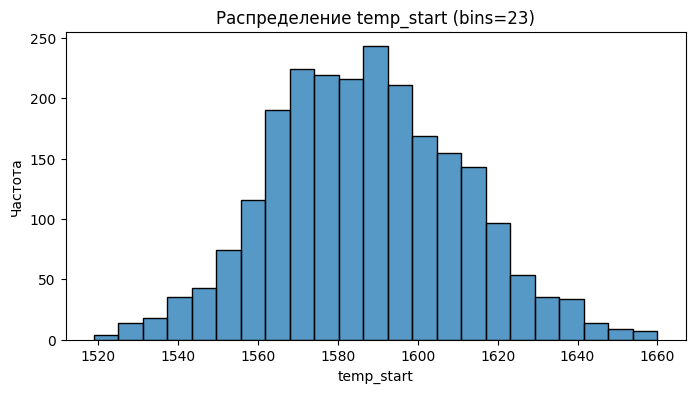

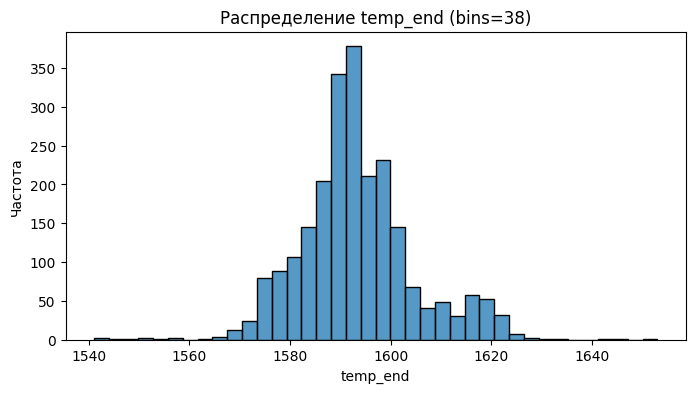

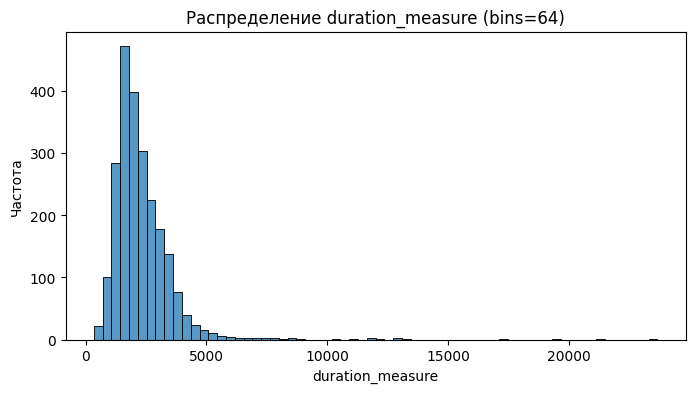

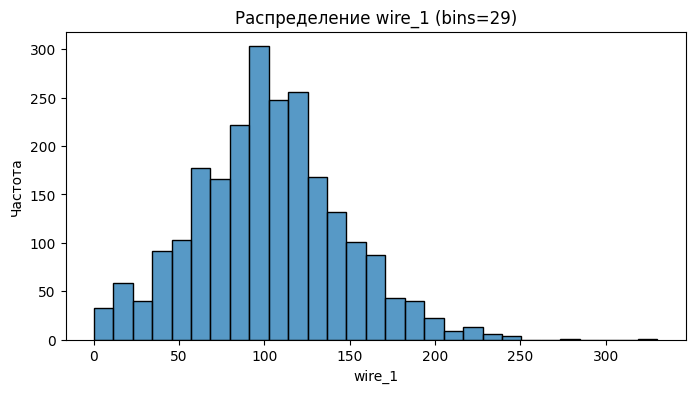

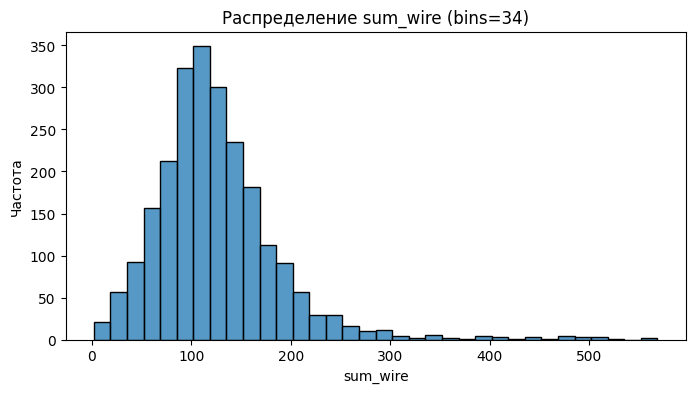

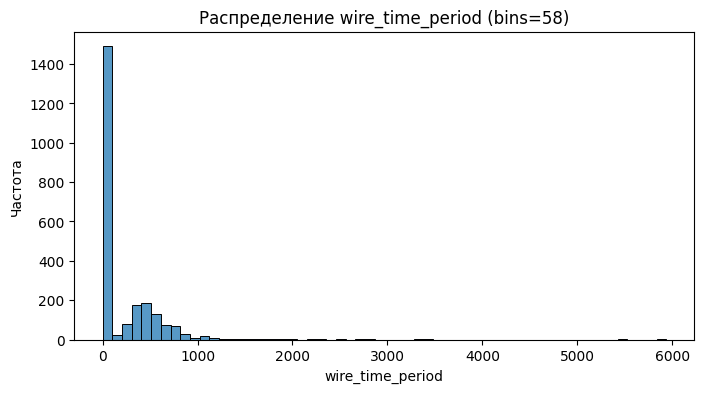

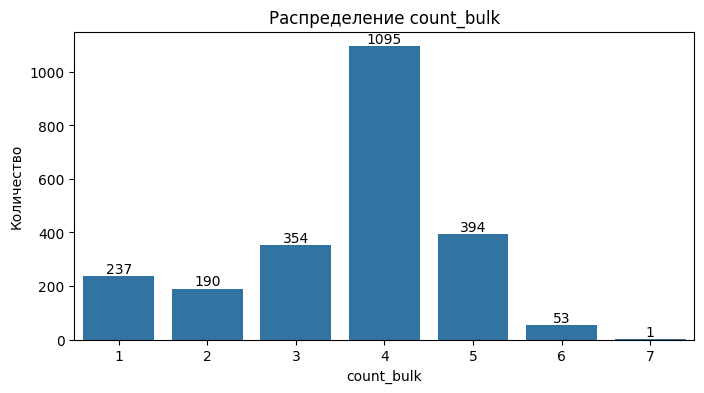

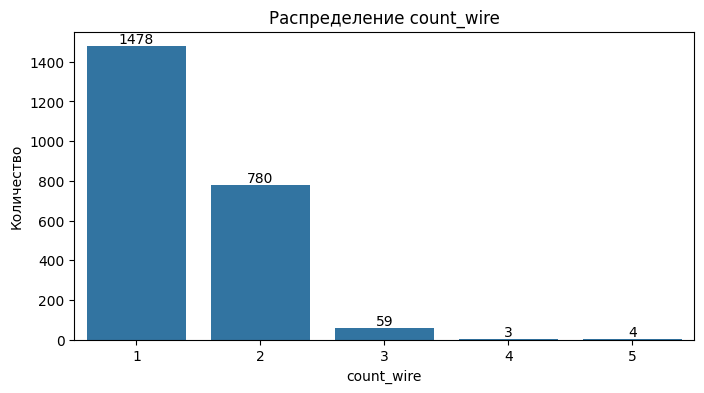

In [72]:
float_features = df.select_dtypes(include=['float64']).columns.tolist()

def scott_bins(data):
    n = len(data)
    sigma = np.std(data)
    bin_width = 3.5 * sigma * (n ** (-1/3))
    if bin_width == 0:
        return 10
    bins = int(np.ceil((data.max() - data.min()) / bin_width))
    return max(1, bins)

for feature in float_features:
    data = df[feature].dropna()
    bins = scott_bins(data)
    plt.figure(figsize=(8, 4))
    sns.histplot(data, bins=bins)
    plt.title(f'Распределение {feature} (bins={bins})')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()


for feature in ['count_bulk', 'count_wire']:
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(x=df[feature])
    plt.title(f'Распределение {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')

    for p in ax.patches:
        height = p.get_height()
        x = p.get_x() + p.get_width() / 2
        y = height
        ax.text(x, y, int(height), ha='center', va='bottom')

    plt.show()

### Вывод

Поочерёдно объединили таблицы по колонке `key`, используя внутреннее объединение (how='inner'). В итоге остались только те партии, которые есть во всех исходных таблицах.

## Корреляционный анализ

In [73]:
# Устанавливаем столбец 'key' в качестве индекса
df.set_index('key', inplace=True)

# Выбираем только столбцы с типом float64
interval = df.select_dtypes(include=['float64']).columns.tolist()

# Вычисляем матрицу Фи корреляции только для float64 столбцов
phik_data = df.phik_matrix(interval_cols=interval)

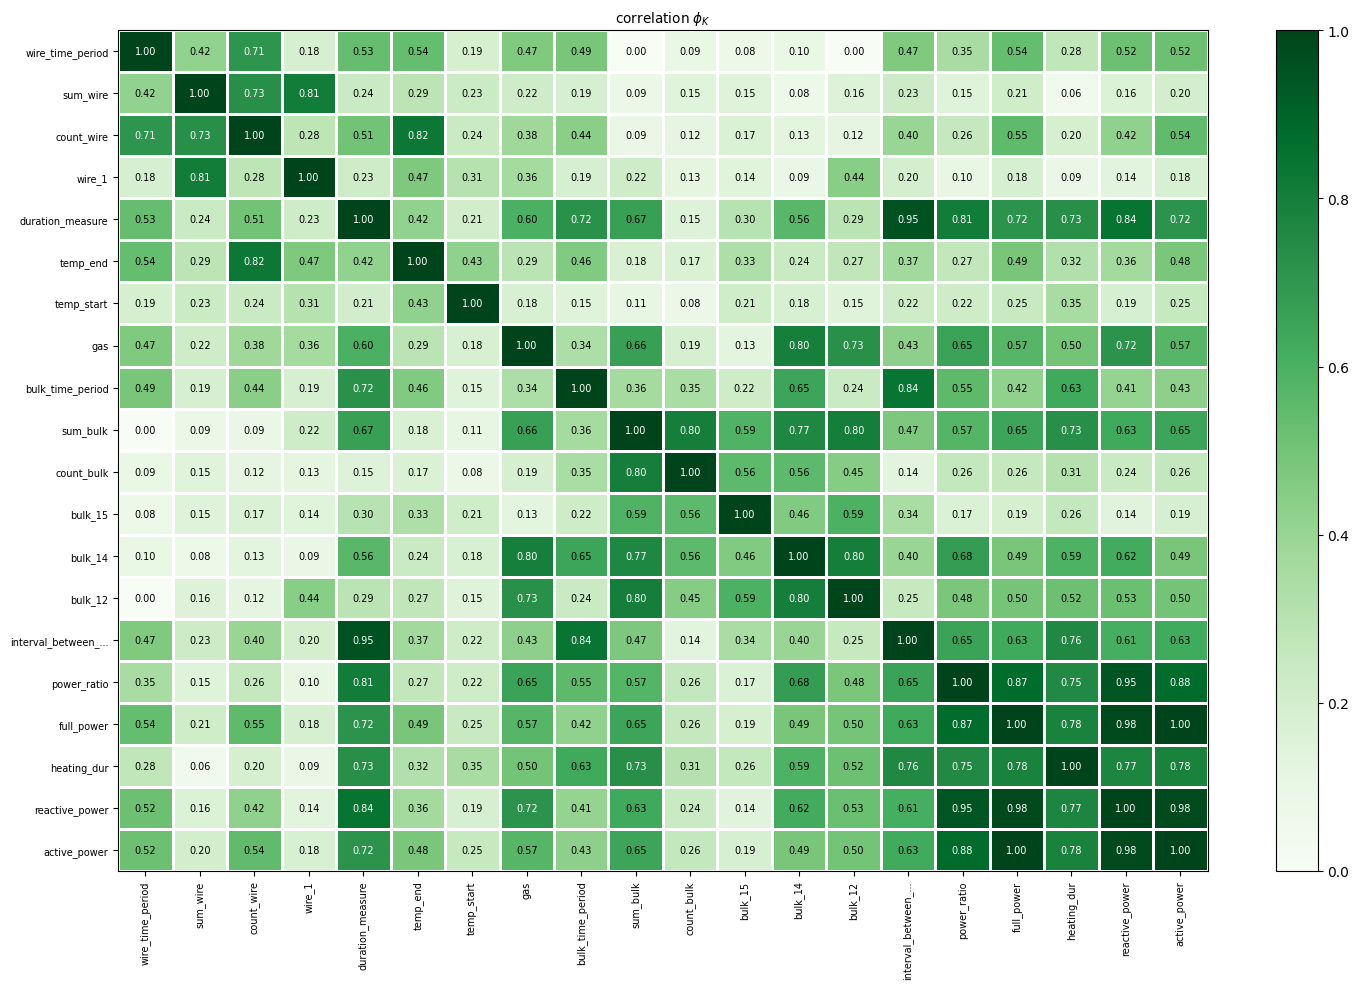

In [74]:
plot_correlation_matrix(phik_data.values,
                        x_labels=phik_data.columns,
                        y_labels=phik_data.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.7,
                        figsize=(15, 10))

In [75]:
# Удаляем столбцы 'active_power' и 'reactive_power'
df.drop(['active_power', 'reactive_power', 'interval_between_heatings'], axis=1, inplace=True)

In [76]:
# Выбираем только столбцы с типом float64
interval = df.select_dtypes(include=['float64']).columns.tolist()

# Вычисляем матрицу Фи корреляции только для float64 столбцов
phik_data = df.phik_matrix(interval_cols=interval)

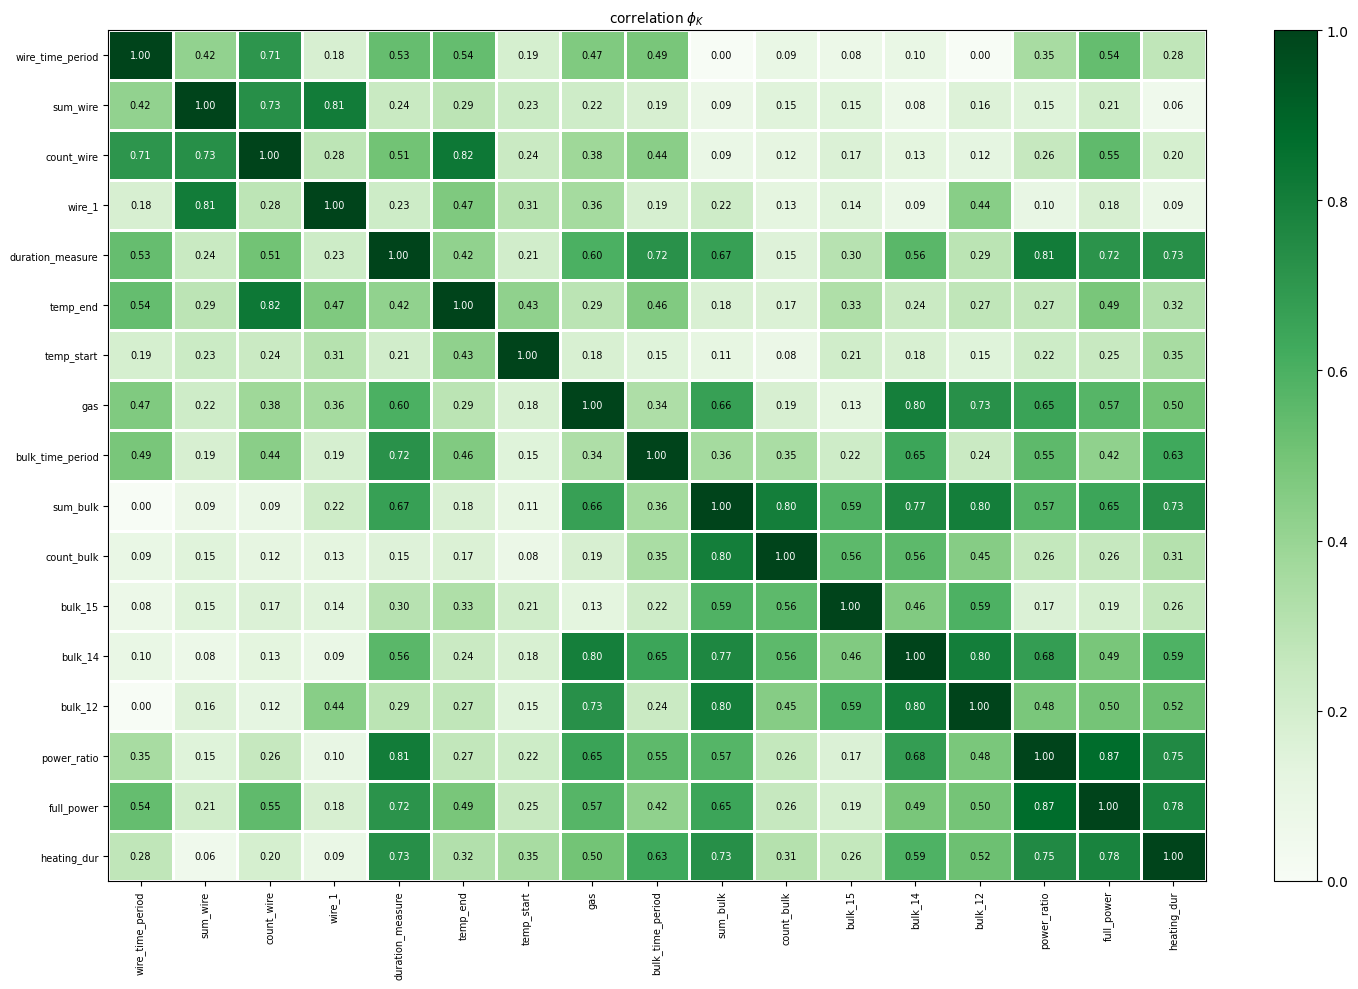

In [77]:
plot_correlation_matrix(phik_data.values,
                        x_labels=phik_data.columns,
                        y_labels=phik_data.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.7,
                        figsize=(15, 10))

**temp_end** имеет высокую положительную корреляцию с:
   - **count_wire (0.824)** — количество провода, возможно, связано с процессом нагрева или количеством материала, влияющего на конечную температуру.
   - **wire_1 (0.4707)** — также связанный с проводом параметр.
   - **duration_measure (0.4195)** — длительность измерения, возможно, время нагрева.
   - **temp_start (0.4252)** — начальная температура, что логично, так как конечная температура зависит от начальной.
   - **wire_time_period (0.5381)** — период времени, связанный с проводом.

**temp_end** имеет умеренную положительную корреляцию с:
   - **full_power (0.4867)** — мощность, подаваемая на нагрев.
   - **bulk_12, bulk_14, bulk_15** — параметры, связанные с bulk (объемом/массовыми характеристиками), но корреляция ниже (около 0.24-0.32).

### Вывод

В данном разделе проведено:

- Расчет матрицы Phik
- Визуализация корреляционной матрицы с помощью colormap
- После удаления мультиколлинеарных столбцов `active_power`, `reactive_power` и `interval_between_heatings`, матрица корреляций была пересчитана для оставшихся признаков.

**Ключевые наблюдения:**
   - `temp_end`  имеет очень сильную положительную корреляцию с `count_wire` (0.824)** — это говорит о том, что количество провода тесно связано с конечной температурой в процессе, возможно, за счёт влияния массы или площади контакта.
   - Также значимы положительные корреляции с `wire_1` (0.471), `wire_time_period` (0.538) и `temp_start` (0.425).

## Подготовка данных к обучению

In [78]:
X = df.drop('temp_end', axis=1)
y = df['temp_end']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

In [79]:
X.shape, y.shape

((2324, 16), (2324,))

In [80]:
print(f'Train: {X_train.shape, y_train.shape}')
print(f'Test: {X_test.shape, y_test.shape}')

Train: ((1743, 16), (1743,))
Test: ((581, 16), (581,))


In [81]:
# Масштабирование
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Вывод

В данном разделе выполнена подготовка данных к обучению модели:

1. **Формирование признаков и целевой переменной:**
   - Из исходного датафрейма `df` выделена целевая переменная `temp_end` в `y`.
   - Остальные признаки, кроме `temp_end`, помещены в `X`.

2. **Разделение данных на обучающую и тестовую выборки:**
   - Использована функция `train_test_split` с параметром `test_size=0.25`, то есть 25% данных отведено под тестовую выборку.
   - Выведены размеры обучающей и тестовой выборок для признаков и целевой переменной, что позволяет убедиться в корректном разбиении.

3. **Масштабирование признаков:**
   - Применён `StandardScaler` для стандартизации признаков обучающей выборки.
   - Трансформированы обе выборки (обучающая и тестовая) с использованием параметров.

## Обучение модели

### Константная модель (DummyRegressor)

In [82]:
%%time
dr_model = DummyRegressor(strategy="mean")
scores = cross_val_score(dr_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
dr_mae = np.mean(np.abs(scores))
print('DummyRegressor MAE:', dr_mae)

DummyRegressor MAE: 8.104357073496626
CPU times: user 20.2 ms, sys: 0 ns, total: 20.2 ms
Wall time: 20.5 ms


### DecisionTreeRegressor

In [83]:
%%time
dtr_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=dtr_model,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
dtr_mae = -grid_search.best_score_

print("Лучшие гиперпараметры DecisionTreeRegressor:", grid_search.best_params_)
print("DecisionTreeRegressor MAE:", dtr_mae)

Лучшие гиперпараметры DecisionTreeRegressor: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
DecisionTreeRegressor MAE: 7.34760721827505
CPU times: user 231 ms, sys: 9.06 ms, total: 240 ms
Wall time: 3.89 s


### CatBoostRegressor

In [84]:
%%time
cbr_model = CatBoostRegressor(verbose=0, random_seed=RANDOM_STATE)

param_grid = {
    'depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'iterations': [100, 200],
}

grid_search = GridSearchCV(estimator=cbr_model,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train, early_stopping_rounds=20)
cbr_mae = -grid_search.best_score_

print("Лучшие гиперпараметрыCatBoostRegressor :", grid_search.best_params_)
print("CatBoostRegressor MAE:", cbr_mae)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие гиперпараметрыCatBoostRegressor : {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
CatBoostRegressor MAE: 6.057572328515449
CPU times: user 2.63 s, sys: 273 ms, total: 2.91 s
Wall time: 2min 39s


### KerasDenseRegression

In [85]:
%%time
INPUT_SHAPE = X_train_scaled.shape[1:]
N_SPLITS = 5
EPOCHS = 200
BATCH_SIZE = 32

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=INPUT_SHAPE),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae']
    )
    return model

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
mae_scores = []

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=20,
    restore_best_weights=True
)

for train_idx, val_idx in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = build_model()
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )

    val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
    mae_scores.append(val_mae)
    print(f'Fold MAE: {val_mae:.4f}')

kdr_mae= np.mean(mae_scores)

print(f'\nKerasDenseRegression MAE: {kdr_mae}')

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1592.9237 - mae: 1592.9237 - val_loss: 1590.9175 - val_mae: 1590.9175
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1588.2209 - mae: 1588.2209 - val_loss: 1580.4644 - val_mae: 1580.4644
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1573.9946 - mae: 1573.9946 - val_loss: 1552.4108 - val_mae: 1552.4108
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1539.4226 - mae: 1539.4226 - val_loss: 1493.1732 - val_mae: 1493.1732
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1466.2910 - mae: 1466.2910 - val_loss: 1388.7692 - val_mae: 1388.7692
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1351.5707 - mae: 1351.5707 - val_loss: 1226.9708 - val_mae: 1226.9708
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1175.9166 - mae: 1175.9166 - val_loss: 1009.7507 - val_mae: 1009.7507
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 958.8267 - mae: 958.8267 - val_loss: 817.8834 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1592.4877 - mae: 1592.4877 - val_loss: 1590.7117 - val_mae: 1590.7117
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1588.4427 - mae: 1588.4427 - val_loss: 1580.5529 - val_mae: 1580.5529
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1575.0334 - mae: 1575.0334 - val_loss: 1552.9874 - val_mae: 1552.9874
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1541.5574 - mae: 1541.5574 - val_loss: 1493.7921 - val_mae: 1493.7921
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1471.6985 - mae: 1471.6985 - val_loss: 1388.4622 - val_mae: 1388.4622
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1352.6462 - mae: 1352.6462 - val_loss: 1238.9263 - val_mae: 1238.9263
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1182.3291 - mae: 1182.3291 - val_loss: 1031.9573 - val_mae: 1031.9573
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 948.7307 - mae: 948.7307 - val_loss: 808.0763 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1593.1727 - mae: 1593.1727 - val_loss: 1589.8655 - val_mae: 1589.8655
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1589.2289 - mae: 1589.2289 - val_loss: 1582.2756 - val_mae: 1582.2756
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1578.7096 - mae: 1578.7096 - val_loss: 1561.6924 - val_mae: 1561.6924
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1551.2551 - mae: 1551.2551 - val_loss: 1516.2965 - val_mae: 1516.2965
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1495.1606 - mae: 1495.1606 - val_loss: 1432.6373 - val_mae: 1432.6373
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1388.9180 - mae: 1388.9180 - val_loss: 1302.4102 - val_mae: 1302.4102
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1233.5096 - mae: 1233.5096 - val_loss: 1119.2935 - val_mae: 1119.2935
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1025.9255 - mae: 1025.9255 - val_loss: 892.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1592.4385 - mae: 1592.4385 - val_loss: 1588.1965 - val_mae: 1588.1965
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1585.4639 - mae: 1585.4639 - val_loss: 1572.5137 - val_mae: 1572.5137
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1564.3723 - mae: 1564.3723 - val_loss: 1531.3868 - val_mae: 1531.3868
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1513.9342 - mae: 1513.9342 - val_loss: 1447.0811 - val_mae: 1447.0811
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1413.0444 - mae: 1413.0444 - val_loss: 1299.6390 - val_mae: 1299.6390
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1260.9711 - mae: 1260.9711 - val_loss: 1076.9425 - val_mae: 1076.9425
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1009.6404 - mae: 1009.6404 - val_loss: 827.4289 - val_mae: 827.4289
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 828.0323 - mae: 828.0323 - val_loss: 685.5773 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1592.4883 - mae: 1592.4883 - val_loss: 1589.1421 - val_mae: 1589.1421
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1587.5680 - mae: 1587.5680 - val_loss: 1577.2915 - val_mae: 1577.2915
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1571.8289 - mae: 1571.8289 - val_loss: 1546.2570 - val_mae: 1546.2570
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1536.0723 - mae: 1536.0723 - val_loss: 1480.8208 - val_mae: 1480.8208
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1458.3434 - mae: 1458.3434 - val_loss: 1364.9237 - val_mae: 1364.9237
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1329.0851 - mae: 1329.0851 - val_loss: 1185.5842 - val_mae: 1185.5842
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1161.4702 - mae: 1161.4702 - val_loss: 944.8876 - val_mae: 944.8876
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 918.7427 - mae: 918.7427 - val_loss: 744.7273 - val_

In [86]:
# Собираем результаты в словарь
results = {
    'Model': ['Dummy Regressor', 'DecisionTreeRegressor', 'CatBoostRegressor', 'KerasDenseRegression'],
    'MAE': [dr_mae, dtr_mae, cbr_mae, kdr_mae]
}

# Создаём DataFrame
results_df = pd.DataFrame(results)

results_df

,Model,MAE
0,Dummy Regressor,8.104357
1,DecisionTreeRegressor,7.347607
2,CatBoostRegressor,6.057572
3,KerasDenseRegression,8.132528


### Вывод

В данном разделе проведено обучение и оценка производительности четырёх моделей:

1. DummyRegressor (константная модель)
- Модель, предсказывающая среднее значение целевой переменной.
- Используется как базовый уровень для сравнения.
- MAE показывает ошибку, которую необходимо превзойти более сложным моделям.

2. DecisionTreeRegressor
- Проведён подбор гиперпараметров (`max_depth`, `min_samples_split`, `min_samples_leaf`) с помощью GridSearchCV.
- Использована 5-fold кросс-валидация и метрика MAE.

3. CatBoostRegressor
- Градиентный бустинг с подбором параметров (`depth`, `learning_rate`, `iterations`).
- Используется кросс-валидация и ранняя остановка для предотвращения переобучения.

4. KerasDenseRegression (нейронная сеть)
- Создана простая полносвязная нейронная сеть с двумя скрытыми слоями.
- Обучение проводилось с кросс-валидацией (5 фолдов) и ранней остановкой.
- MAE по валидационным фолдам усреднён для оценки качества.

Результаты собраны в таблицу для удобного сравнения, что облегчает выбор лучшей модели для дальнейшего использования. Лучшая модель – `CatBoostRegressor` (MAE = 6.058).


## Тестирование модели

Проверим качество лучшей модели на тестовой выборке. Значение метрики MAE должно быть менее 6.8.

In [87]:
best_cbr_model = grid_search.best_estimator_

y_pred = best_cbr_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE на тестовой выборке: {test_mae:.4f}")

MAE на тестовой выборке: 5.9251


### Вывод

MAE на тестовой выборке 5.9251 удовлетворяет условию задачи.

### Анализ важности признаков

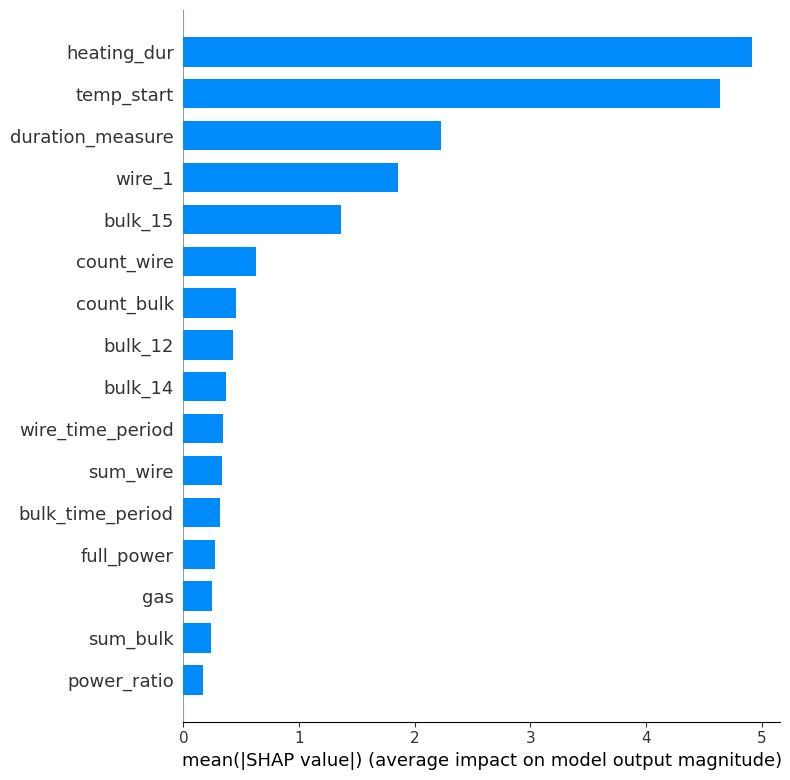

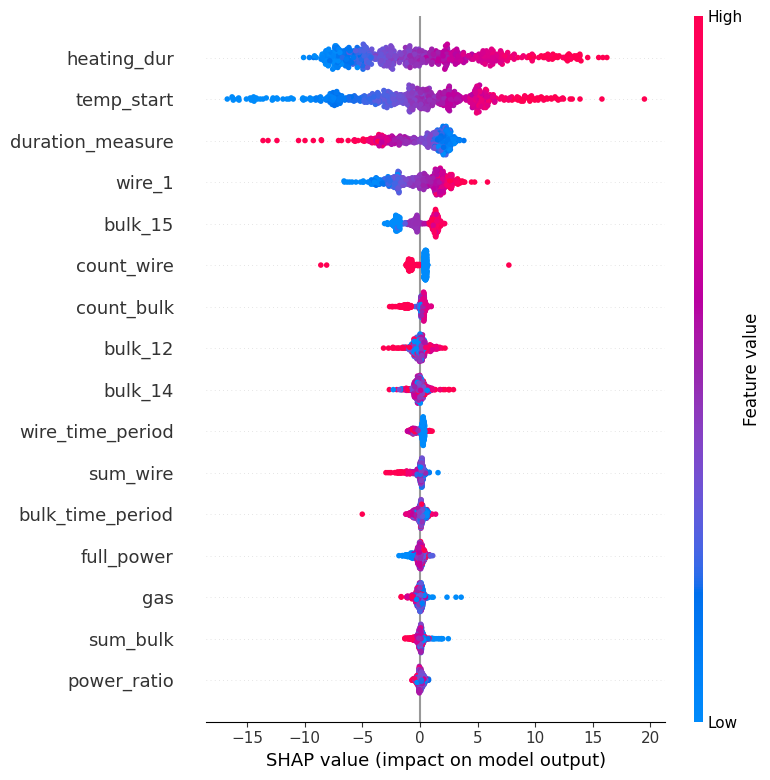

In [88]:
test_pool = Pool(data=X_test)

explainer = shap.TreeExplainer(best_cbr_model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)

На основании представленного можно сделать следующие выводы:

1. **Ключевые признаки:**
   - **heating_dur** — самый важный признак, оказывающий наибольшее влияние на предсказания модели. Это говорит о том, что длительность нагрева является главным фактором, определяющим целевую переменную.
   - **temp_start** — второй по значимости признак, что логично, так как начальная температура, вероятно, напрямую связана с процессом и результатом нагрева.
   
2. **Средневажные признаки:**
   - **duration_measure** — занимает третье место по важности, вероятно, отражает дополнительную информацию о времени измерения или длительности процесса.
   - **wire_1** и **bulk_15** — признаки со средней важностью, которые могут отражать характеристики оборудования или условий, влияющих на процесс.

3. **Менее значимые признаки:**
   - Признаки типа **count_wire**, **count_bulk**, **bulk_12**, **bulk_14**, **wire_time_period**, **sum_wire**, **bulk_time_period**, **full_power**, **gas** имеют относительно низкое влияние на предсказания модели.

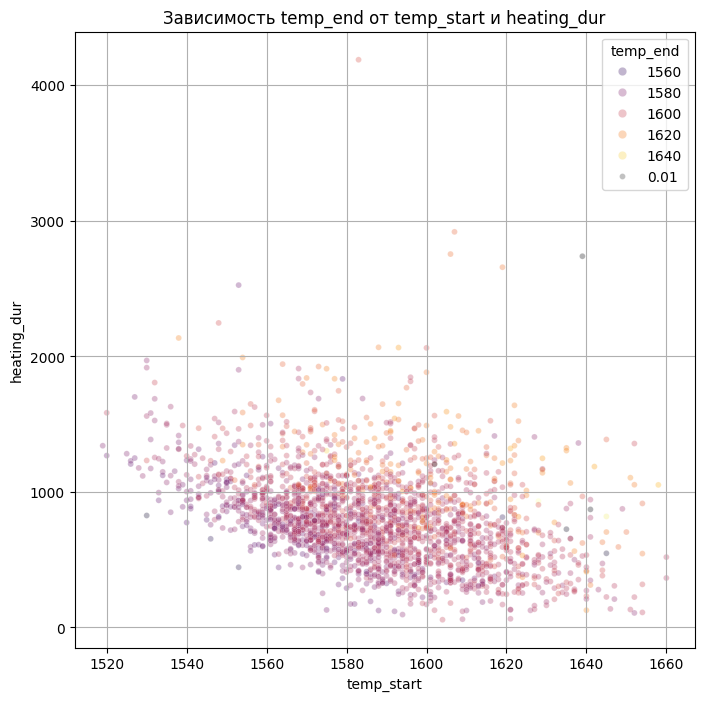

In [89]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x='temp_start', y='heating_dur', hue='temp_end', alpha=0.3, size=0.01, palette='inferno')
plt.xlabel('temp_start')
plt.ylabel('heating_dur')
plt.title('Зависимость temp_end от temp_start и heating_dur')
plt.grid(True)
plt.show()

**Зависимость между `temp_start` и `heating_dur`:**
   - При увеличении начальной температуры (**temp_start**) длительность нагрева (**heating_dur**) в среднем уменьшается. Чем выше начальная температура, тем меньше времени требуется для нагрева до нужного уровня.

**Связь конечной температуры (`temp_end`) с начальной температурой и длительностью нагрева:**
   - Точки с более высокими значениями конечной температуры сосредоточены в области с более высокими значениями `temp_start` и более низкими значениями `heating_dur`. Это говорит о том, что для достижения более высокой конечной температуры достаточно относительно короткого нагрева, если начальная температура уже высокая.
   
**Разброс данных:**
   - При низких значениях начальной температуры наблюдается большой разброс длительности нагрева, что указывает на вариативность процесса нагрева при низком начальном уровне.
   - При высоких значениях `temp_start` разброс `heating_dur` меньше, процесс более предсказуем.
   - Для достижения определённого конечного уровня температуры существует компромисс между начальной температурой и длительностью нагрева: либо высокая начальная температура и короткий нагрев, либо низкая начальная температура и длительный нагрев.

### Вывод

В данном разделе проведен анализ важности признаков и визуализация взаимосвязей:

- С помощью метода SHAP мы смогли оценить вклад каждого признака в итоговые предсказания модели.
- Наиболее сильное влияние на целевую переменную оказывают признаки `heating_dur` и `temp_start`.
- Визуализация с помощью scatter plot показывает важную взаимосвязь: при увеличении стартовой температуры `temp_start` длительность нагрева `heating_dur` в среднем сокращается. Это отражает физическую логику процесса — чем выше начальная температура, тем меньше времени требуется для достижения целевого уровня.
- Наблюдается компромисс между двумя признаками — короткий нагрев при высокой начальной температуре и длительный нагрев при низкой начальной.

## Общий вывод

Построенная модель позволяет предсказывать температуру стали с высокой точностью (MAE=5.93), что создаёт основу для оптимизации энергопотребления на этапе нагрева. Внедрение модели позволит комбинату снизить производственные расходы за счёт более эффективного управления процессом обработки стали.

Проведенная работа:
- Данные собираются из нескольких таблиц с разной информацией (электроды, сыпучие материалы, газ, проволока, температура).
- Выполнена тщательная предобработка (приведение типов, работа с пропусками, удаление аномалий, создание новых признаков).
- Проведен EDA — изучены распределения, корреляции, связь признаков с целью.
- Объединены данные по номеру партии (`key`).
- Обучены несколько моделей (DummyRegressor, DecisionTreeRegressor, CatBoostRegressor, Keras нейросеть).
- Лучшей оказалась модель CatBoost с MAE ~6 на кросс-валидации и ~5.9 на тесте.
- Анализ важности признаков через SHAP выявил главную роль длительности нагрева (`heating_dur`) и стартовой температуры (`temp_start`).
- Визуализация показала компромисс между начальной температурой и временем нагрева для достижения конечной температуры.

**Бизнес-рекомендации заказчику**

1. **Интеграция модели в систему управления:**
   - Использовать модель для прогнозирования температуры в режиме реального времени с автоматической подстройкой режима нагрева и подачи материалов.
   - Это позволит снизить энергопотребление за счёт оптимизации времени нагрева.

2. **Оптимизация процессов на основе модели:**
   - Управлять длительностью нагрева в зависимости от стартовой температуры, тем самым оставаясь в пределах целевой конечной температуры и снижая время простоя.

3. **Контроль и мониторинг:**
   - Настроить систему уведомлений при отклонениях от оптимального режима (например, аномально долгий нагрев при высокой стартовой температуре) для быстрого реагирования.
   - Анализировать причины отклонений с целью предотвращения брака и повышения качества продукции.